In [1]:
from dask_jobqueue import SLURMCluster
NCORES = 8
NPROCESS = 8
NCORESPERPROCESS = NCORES//NPROCESS
constraints = ['-C \"CLASS:SH4_CBASE|CLASS:SH4_CPERF\"']
cluster = SLURMCluster(queue='serc',memory='64GiB',cores=NCORES,processes=NPROCESS,interface='ib0',walltime='06:00:00',job_extra_directives=constraints)
cluster.adapt(minimum_jobs=25,maximum_jobs=60)
cluster



Dashboard: http://10.52.7.13:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.52.7.13:45477,Workers: 0
Dashboard: http://10.52.7.13:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [2]:
from dask.distributed import Client 
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.52.7.13:8787/status,
Dashboard: http://10.52.7.13:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.52.7.13:45477,Workers: 0
Dashboard: http://10.52.7.13:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np 
import dask.array as da
import cartopy.crs as ccrs 

PATH_COARSE = 'gs://gcp-public-data-arco-era5/ar/1959-2022-1h-240x121_equiangular_with_poles_conservative.zarr'

In [4]:
ds = xr.open_zarr(PATH_COARSE,chunks={})


In [5]:
ds_4xdaily = ds.sel(time=slice('2014-01-01',None,6))
ds_4xdaily = ds_4xdaily.isel(level=slice(None,None,-1))
ds_4xdaily

<xarray.Dataset> Size: 316GB
Dimensions:                                           (time: 11688,
                                                       longitude: 240,
                                                       latitude: 121, level: 37)
Coordinates:
  * latitude                                          (latitude) float64 968B ...
  * level                                             (level) int64 296B 1000...
  * longitude                                         (longitude) float64 2kB ...
  * time                                              (time) datetime64[ns] 94kB ...
Data variables: (12/31)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 1GB dask.array<chunksize=(2, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 1GB dask.array<chunksize=(2, 240, 121), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 1GB dask.array<chunksize=(2, 240, 121), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 116kB dask.array<chunksize=(240, 121), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 116kB dask.array<chunksize=(240, 121), meta=np.ndarray>
    geopotential                                      (time, level, longitude, latitude) float32 50GB dask.array<chunksize=(2, 37, 240, 121), meta=np.ndarray>
    ...                                                ...
    total_precipitation                               (time, longitude, latitude) float32 1GB dask.array<chunksize=(2, 240, 121), meta=np.ndarray>
    type_of_high_vegetation                           (longitude, latitude) float32 116kB dask.array<chunksize=(240, 121), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 116kB dask.array<chunksize=(240, 121), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 50GB dask.array<chunksize=(2, 37, 240, 121), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 50GB dask.array<chunksize=(2, 37, 240, 121), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 50GB dask.array<chunksize=(2, 37, 240, 121), meta=np.ndarray>

In [6]:
variables = ['u_component_of_wind','temperature','geopotential']
ds_4xdaily_reduce = ds_4xdaily[variables]
ds_4xdaily_reduce = ds_4xdaily_reduce.chunk({'time':1})

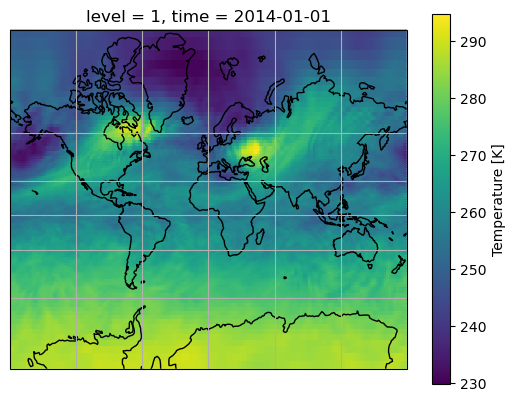

In [7]:
ax = plt.axes(projection=ccrs.Mercator())
ds_4xdaily_reduce.temperature.isel(time=0,level=-1).plot(ax=ax,x='longitude',y='latitude',transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

In [8]:
from constants import GRAV,C_P,BFLIM,R_DRY
demo = ds_4xdaily_reduce
demo = demo.transpose("time","longitude","latitude","level")
us = demo.u_component_of_wind
temps = demo.temperature
height = demo.geopotential / GRAV

dTdz = da.gradient(temps,axis=-1)/da.gradient(height,axis=-1)
Ns2 = GRAV/temps*(dTdz + GRAV/C_P) 
Ns2 = da.where(Ns2 < BFLIM ** 2, BFLIM **2 , Ns2 )
Ns = Ns2 ** 0.5 
Ns = xr.DataArray(Ns,dims=temps.dims,coords=temps.coords)
rho = (100*temps.level.data.astype(np.float32)[None,None,None,:]/(R_DRY*temps))

In [9]:
lat = da.broadcast_to(demo.latitude.data[None,None,:],us.shape[:-1]).astype(np.float32).persist()
lat = lat.rechunk((1,-1,-1,))

In [10]:
import dask 
from dask.distributed import wait,progress

us,height,Ns,rho = dask.persist(us,height,Ns,rho)
us =us.data
rho = rho.data
Ns = Ns.data
height = height.data
wait(Ns)
wait(rho)


/home/groups/aditis2/robcking/condaenvs/ad99py/lib/python3.13/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 11.39 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('divide-f32b6492ad77112e91854d6753a587b5', 3192, 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('divide-f32b6492ad77112e91854d6753a587b5', 9015, 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('divide-f32b6492ad77112e91854d6753a587b5', 8365, 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('divide-f32b6492ad77112e91854d6753a587b5', 7376, 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('divide-f32b6492ad77112e91854d6753a587b5', 3674, 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('divide-f32b6492ad77112e91854d6753a587b5', 1254, 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('divide-f32b6492ad77112e91854d6753a587b5', 5790, 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('divide-f32b6492ad77112e91854d6753a587b5', 8256, 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('divide-f32b6492ad77112e91854d6753a587b5', 3182, 0, 0, 0)>, <Future: finished,

In [11]:
from ad99 import AlexanderDunkerton1999
ad99 = AlexanderDunkerton1999(Fs0=4.3e-3,cw=35,exclude_unbroken=True,use_intrinsic_c=10.0)

In [12]:


def dask_ad99_map_block(ublock,Nblock,zblock,rhoblock,latblock):
    batch_shape = ublock.shape[:-1]
    nlevels = ublock.shape[-1]
    
    ublock_flt = ublock.reshape((-1,nlevels))
    Nblock_flt = Nblock.reshape((-1,nlevels))
    zblock_flt = zblock.reshape((-1,nlevels))
    rhoblock_flt = rhoblock.reshape((-1,nlevels))
    latblock_flt = latblock.ravel()
    results = np.array([
        ad99.momentum_flux_neg_ptv(u,N,z,rho,lat) for u,N,z,rho,lat in zip(ublock_flt,Nblock_flt,zblock_flt,rhoblock_flt,latblock_flt)
    ])
    
    result_shp =  results.reshape((*batch_shape,2,nlevels))
    result_rtn = np.moveaxis(result_shp,-2,-1)
    return result_rtn

In [13]:
lat_4d = lat[..., None]         # now shape = (11688, 240, 121, 1)
lat_4d = lat_4d.rechunk((1,-1,-1,-1)).persist()

In [14]:
result = da.map_blocks(dask_ad99_map_block,us,Ns,height,rho,lat_4d,new_axis=len(us.shape),dtype=us.dtype,chunks=tuple(c[0] for c in us.chunks) + (2,))

In [15]:
ntv = result[...,0]
ptv = result[...,1]

In [16]:
from ad99dask import AlexanderDunkerton1999Dask
ad99_dask = AlexanderDunkerton1999Dask(Fs0=4.3e-4,cw=35,exclude_unbroken=True,use_intrinsic_c=10.0)dsdsdsiuenfgieurngiuerngieurngeiurgiuergnieurgnfewfewfwef

In [17]:
dims = ('time','longitude','latitude','level')

ds_data = xr.Dataset({
    'u':(dims,us),
    'Ns':(dims,Ns),
    'z':(dims,height),
    'rho':(dims,rho),
    'gw_flux_negative':(dims,ntv),
    'gw_flux_positive':(dims,ptv),
},coords={
    'time':('time',demo.time.values),
    'longitude':('longitude',demo.longitude.values),
    'latitude':('latitude',demo.latitude.values),
    'level':('level',demo.level.values)
})

In [18]:
for var in ds_data.data_vars:
    v = ds_data[var]
    print(f"{var}: type={type(v.data)}")

u: type=<class 'dask.array.core.Array'>
Ns: type=<class 'dask.array.core.Array'>
z: type=<class 'dask.array.core.Array'>
rho: type=<class 'dask.array.core.Array'>
gw_flux_negative: type=<class 'dask.array.core.Array'>
gw_flux_positive: type=<class 'dask.array.core.Array'>


In [19]:
ds_data.to_zarr('/scratch/users/robcking/era5_coarse.zarr',mode='w',zarr_format=2,encoding=None)

/home/groups/aditis2/robcking/condaenvs/ad99py/lib/python3.13/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.99 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [21]:
ds_data.sel(time='2015').to_netcdf('/scratch/users/robcking/era5_coarse_2015.nc')

In [7]:
ds_data.to_zarr('/scratch/users/robcking/era5_coarse.zarr',mode='w',zarr_format=2,encoding=None)

/home/groups/aditis2/robcking/condaenvs/ad99py/lib/python3.13/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 11.58 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


## Load Data